# Evaluation using LLM Judge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import InferenceClient
# Hugging Face client setup
client = InferenceClient(
    provider="hf-inference",
    api_key='[YOUR_HUGGING_FACE_TOKEN]',
)

In [ ]:
import os
import pandas as pd
import csv
import time
import re

# Load input CSV
df = pd.read_csv("/content/output.csv",skiprows=range(1, 24))

output_file = "llama_evaluated_output_batch2.csv"

# If the file doesn't exist, create it with headers
if not os.path.exists(output_file):
    with open(output_file, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=[
            *df.columns, "Relevance", "Quality", "Correctness", "Fluency", "Creativity", "Comment",
            "Feedback_Relevance", "Feedback_Quality", "Feedback_Correctness", "Feedback_Fluency", "Feedback_Creativity", "Feedback_Comment"
        ])
        writer.writeheader()

# Prepare storage
evaluated_rows = []

# Helper function to parse evaluation response into structured scores
def parse_scores(text):
    result = {
        "Relevance": None,
        "Quality": None,
        "Correctness": None,
        "Fluency": None,
        "Creativity": None,
        "Comment": ""
    }

    pattern = r"(Relevance|Quality|Correctness|Fluency|Creativity):\s*(\d)"
    matches = re.findall(pattern, text)
    for key, val in matches:
        result[key] = int(val)

    comment_match = re.search(r"Comment:\s*(.*)", text, re.DOTALL)
    if comment_match:
        result["Comment"] = comment_match.group(1).strip()

    return result

# Loop through each row and evaluate
for idx, row in df.iterrows():
    print(f"Processing row {idx}")

    image_url = row["Image"]
    tags = row["Tags"]
    matched_place = row["Matched Place"]
    place_description = row["Place Description"]
    gen_desc = row["Generated Description"]
    feedback_text = row.get("Feedback text", "")
    feedback_output = row.get("Generated feedback output", "")

    # ---------- DESCRIPTION EVALUATION ----------
    desc_prompt = f"""
You are an expert travel evaluator.

Evaluate the following generated travel description based on these inputs:

Tags: {tags}
Matched Place: {matched_place}
Place Description: {place_description}

Generated Description: {gen_desc}

Provide a score from 1 to 5 for each of these:
- Relevance
- Quality
- Correctness
- Fluency
- Creativity

Then provide a short comment justifying your evaluation.

Your output format:
Relevance: <score>
Quality: <score>
Correctness: <score>
Fluency: <score>
Creativity: <score>
Comment: <your comment>
"""

    try:
        desc_response = client.chat.completions.create(
            model="meta-llama/Llama-3.2-11B-Vision-Instruct",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": desc_prompt}
                    ],
                }
            ],
        )
        desc_text = desc_response.choices[0].message.content
        desc_scores = parse_scores(desc_text)

    except Exception as e:
        desc_scores = {k: 0 for k in ["Relevance", "Quality", "Correctness", "Fluency", "Creativity"]}
        desc_scores["Comment"] = f"ERROR: {str(e)}"

    time.sleep(1)

    # ---------- FEEDBACK EVALUATION ----------
    if feedback_output and isinstance(feedback_output, str) and len(feedback_output.strip()) > 0:
        fb_prompt = f"""
Evaluate the following Generated Feedback Output for helpfulness and alignment with the user request.

Tags: {tags}
Feedback prompt: {feedback_text}

Generated Feedback Output:
{feedback_output}

Score from 1 to 5 on:
- Feedback_Relevance
- Feedback_Quality
- Feedback_Correctness
- Feedback_Fluency
- Feedback_Creativity

Also add a short justification.

Output format:
Feedback_Relevance: <score>
Feedback_Quality: <score>
Feedback_Correctness: <score>
Feedback_Fluency: <score>
Feedback_Creativity: <score>
Feedback_Comment: <your comment>
"""
        try:
            fb_response = client.chat.completions.create(
                model="meta-llama/Llama-3.2-11B-Vision-Instruct",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": fb_prompt}
                        ],
                    }
                ],
            )
            fb_text = fb_response.choices[0].message.content
            fb_scores = parse_scores(fb_text)
            # Rename keys to feedback fields
            fb_scores = {
                "Feedback_Relevance": fb_scores["Relevance"],
                "Feedback_Quality": fb_scores["Quality"],
                "Feedback_Correctness": fb_scores["Correctness"],
                "Feedback_Fluency": fb_scores["Fluency"],
                "Feedback_Creativity": fb_scores["Creativity"],
                "Feedback_Comment": fb_scores["Comment"]
            }

        except Exception as e:
            fb_scores = {
                "Feedback_Relevance": 0,
                "Feedback_Quality": 0,
                "Feedback_Correctness": 0,
                "Feedback_Fluency": 0,
                "Feedback_Creativity": 0,
                "Feedback_Comment": f"ERROR: {str(e)}"
            }
    else:
        # No feedback provided
        fb_scores = {
            "Feedback_Relevance": 3,
            "Feedback_Quality": 3,
            "Feedback_Correctness": 3,
            "Feedback_Fluency": 3,
            "Feedback_Creativity": 3,
            "Feedback_Comment": "No feedback text provided."
        }

    # ---------- Save combined result ----------
    evaluated_rows.append({
        **row,
        **desc_scores,
        **fb_scores
    })

    print(evaluated_rows[-1])
    time.sleep(1)  # Avoid rate limit

# Write to CSV
with open(output_file, mode='w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=evaluated_rows[0].keys())
    writer.writeheader()
    writer.writerows(evaluated_rows)

print(f"CSV saved to {output_file}")


Processing row 0
{'Matched Place': 'Big Sur', 'Generated Description': 'What a stunning place! A similar travel destination could be Bali, Indonesia. Tucked away in the heart of Southeast Asia, Bali is a paradise with water and splashes of culture in every corner. Known as the Island of the Gods, Bali is a small island in Indonesia that offers an enchanting experience for the visitors. It is famous for its mesmerizing rice terraces, waterfalls, and wave-kissed beaches, especially in the Bukit Peninsula. If you are a water baby, head to Padang Padang Beach, a surfing destination with awe-inspiring waves for all levels of surfers. Its tropical climate and lush green vegetation make it a favoured spot for surfers. The Ubud Monkey Forest is an internationally recognised cultural hotspot. Monkeys roam free in this heavenly abode with picturesque temples, lush paddy fields,', 'Feedback text': 'Suggest me something  Warm.', 'Place Description': 'ocean water and', 'Tags': 'water, splashing, up

In [ ]:
import pandas as pd

# Step 1: Load the CSV
input_csv = "/content/llama_evaluated_output.csv"
df = pd.read_csv(input_csv)

# Step 2: Identify the image column automatically (or specify manually)
image_col = "Image"

# Step 3: Drop duplicate image entries, keeping the first occurrence
unique_df = df.drop_duplicates(subset=image_col, keep="first")

# Step 4: Save to new CSV
output_csv = "unique_image_rows.csv"
unique_df.to_csv(output_csv, index=False)

print(f"✅ Saved {len(unique_df)} unique image rows to '{output_csv}' (based on column '{image_col}')")


✅ Saved 42 unique image rows to 'unique_image_rows.csv' (based on column 'Image')


In [ ]:
import pandas as pd

# Read both CSVs
df1 = pd.read_csv('/content/unique_image_rows.csv')
df2 = pd.read_csv('/content/llama_evaluated_output_batch2.csv')

# Combine rows
df_combined = pd.concat([df1, df2], ignore_index=True)

# Save result
df_combined.to_csv('final_llama_eval_output.csv', index=False)


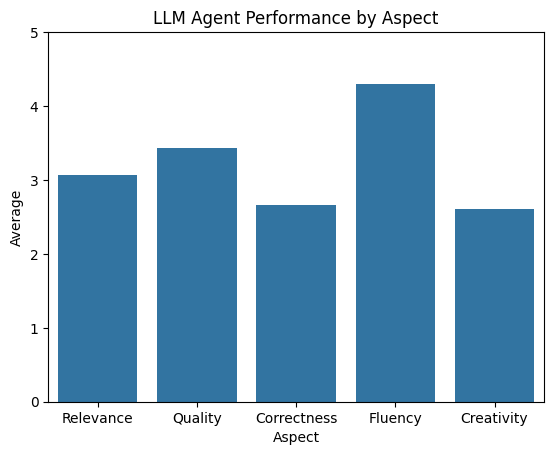

In [ ]:
import seaborn as sns

df = pd.read_csv('/content/final_merged_llama_eval_output.csv', encoding='ISO-8859-1')

mean_scores = df[['Relevance', 'Quality', 'Correctness', 'Fluency', 'Creativity']].mean().reset_index()
mean_scores.columns = ['Aspect', 'Average']

sns.barplot(x='Aspect', y='Average', data=mean_scores)
plt.title('LLM Agent Performance by Aspect')
plt.ylim(0, 5)
plt.show()


Overall Mean Score: 3.21


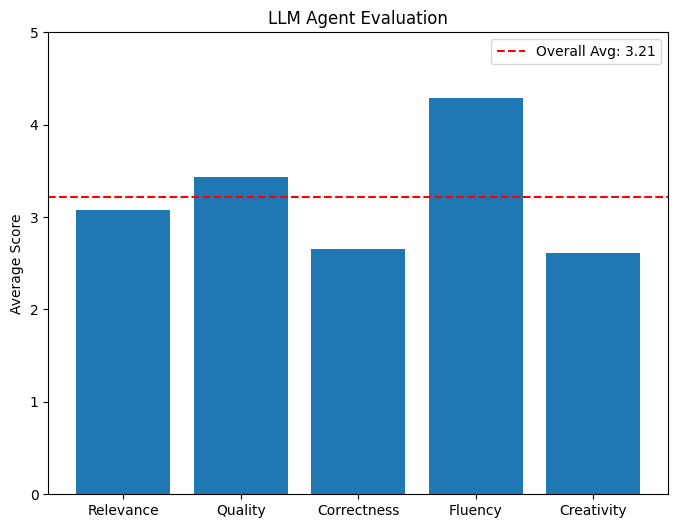

In [ ]:
# Overall score per row
df['Overall'] = df[['Relevance', 'Quality', 'Correctness', 'Fluency', 'Creativity']].mean(axis=1)

# Mean scores
mean_scores = df[['Relevance', 'Quality', 'Correctness', 'Fluency', 'Creativity']].mean()
overall_mean = df['Overall'].mean()

print(f"Overall Mean Score: {overall_mean:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.bar(mean_scores.index, mean_scores.values)
plt.axhline(overall_mean, color='red', linestyle='--', label=f'Overall Avg: {overall_mean:.2f}')
plt.title('LLM Agent Evaluation')
plt.ylabel('Average Score')
plt.ylim(0, 5)
plt.legend()
plt.show()


Overall Mean Score: 4.11


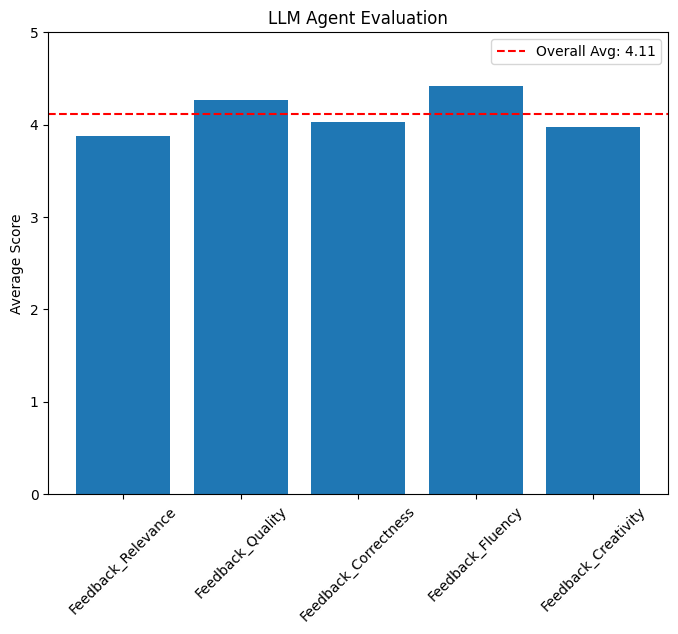

In [ ]:
# Overall score per row
df['Overall'] = df[['Feedback_Relevance', 'Feedback_Quality', 'Feedback_Correctness', 'Feedback_Fluency', 'Feedback_Creativity']].mean(axis=1)

# Mean scores
mean_scores = df[['Feedback_Relevance', 'Feedback_Quality', 'Feedback_Correctness', 'Feedback_Fluency', 'Feedback_Creativity']].mean()
overall_mean = df['Overall'].mean()

print(f"Overall Mean Score: {overall_mean:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.bar(mean_scores.index, mean_scores.values)
plt.axhline(overall_mean, color='red', linestyle='--', label=f'Overall Avg: {overall_mean:.2f}')
plt.title('LLM Agent Evaluation')
plt.ylabel('Average Score')
plt.ylim(0, 5)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()